# TIES451 course. Programming assignment 2 #

Konstantin Sakharovskiy. Sources used:
 - Lecture slides
 - Papers by Eberhart and Kennedy
 - Several open-source GA implementations, especially https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/

## TASK 1 Implement  global paradigm to solve the problem ##

**Step 1.** - make all required imports, defining functions and constraints 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def f(x,y):
    return (np.cos(x) * np.cos(y) - (x / (y ** 2 + 1)))
BOUNDS = [(-1, 2), (-1, 1)] 


**Step2.** Determination of hyperparameters, setting the initial swarm, determining the grid and calculating the maximum function in the grid

In [16]:
# Compute and plot the function in 3D within [-1,2]x[-1,1]
x, y = np.array(np.meshgrid(np.linspace(-1,2,200), np.linspace(-1,1,200)))
z = f(x, y)


# Find the global minimum
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]

 
'''
Hyper-parameter of the algorithm. 

here I am compelled to point out that the hyperparameter requirement
as ACC_CONST = 2 turned out to be practically impossible, due to the fact 
that particles with such a parameter instantly flew out of the constraints 
and I could not find such a control of the constraints so that the optimization 
problem would not get stuck at some point that is far from optimal. 
Animation with behaviour at ACC_CONST = 2 will be shown at the end.

'''

ACC_CONST  = 0.1 # Let see results of this parametr, giving feasible solution 
w = 0.8 # constant inertia weight (how much to weigh the previous velocity)
Vmax = 3


# Create particles
n_particles = 20
np.random.seed(100)
X = np.random.uniform(-1, 1, size = (2, n_particles))
V =  np.random.randn(2, n_particles) * 0.1

# Initialize data
pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
#lbest = neighbor_search(X)
print(pbest)
gbest_obj = pbest_obj.min()

[[ 0.08680988 -0.44326123 -0.15096482  0.68955226 -0.99056229 -0.75686176
   0.34149817  0.65170551 -0.72658682  0.15018666  0.78264391 -0.58159576
  -0.62934356 -0.78324622 -0.56060501  0.95724757  0.6233663  -0.65611797
   0.6324495  -0.45185251]
 [-0.13659163  0.88005964  0.63529876 -0.3277761  -0.64917909 -0.25433591
  -0.98862299 -0.49514729  0.59132502 -0.96949006  0.19768675  0.20760908
  -0.78970463 -0.23611311 -0.92704789  0.78082313  0.96184171 -0.88011602
   0.78109189  0.153803  ]]


In [15]:
#def neighbor_search(flock):
#    distance = list()
#    for i in range(n_particles):
#        distance[i] = 
#    neighbor_index = 
#    return position
    

**Step 3.** Defining the main function in an anti-pattern style from an object-oriented programming point of view

In [3]:
def update():
    "Function to do one iteration of particle swarm optimization"
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    
    # Update velocity according to limits
    r1, r2 = np.random.rand(2)
    for i in range(len(X)):
        for j in range(len(X[i])):
            term1 = w * V[i][j] 
            term2 = ACC_CONST * r1 * (pbest[i][j] - X[i][j])
            term3 = ACC_CONST * r2 * (gbest[i] - X[i][j])
            V[i][j] = term1 + term2 + term3
            if abs(V[i][j]) > Vmax:
                V[i][j] = 0
    
    # updating position, constraints handler as shrink the 
    # velocity of the particle such that it lands on the bounds
    # https://github.com/ljvmiranda921/pyswarms
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] = X[i][j] + V[i][j]
            if X[i][j] < BOUNDS[i][0]:
                X[i][j] = BOUNDS[i][0]
                V[i][j] = 0
            elif X[i][j] > BOUNDS[i][1]:
                X[i][j] = BOUNDS[i][1]
                V[i][j] = 0
    obj = f(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()

**Step4.** Define visualization slides and animation (a tribute to the source for the clarity)

(-1.0, 1.0)

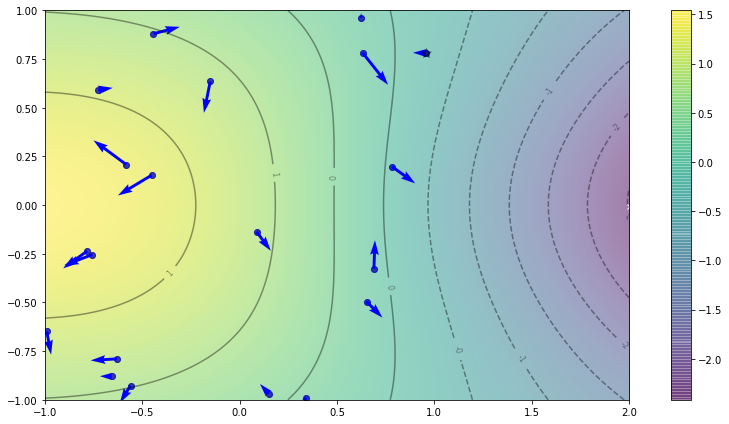

In [4]:
# Set up base figure: The contour map
fig, ax = plt.subplots(figsize=(12,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[-1, 2, -1, 1], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
ax.set_xlim([-1,2])
ax.set_ylim([-1,1])

In [5]:
def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    # Update params
    update()
    # Set picture
    ax.set_title(title)
    pbest_plot.set_offsets(pbest.T)
    p_plot.set_offsets(X.T)
    p_arrow.set_offsets(X.T)
    p_arrow.set_UVC(V[0], V[1])
    gbest_plot.set_offsets(gbest.reshape(1,-1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot

**Step 5.** Run the animation with 100 frames (ACC_CONST = 0.1!)

In [6]:
anim = FuncAnimation(fig, animate, frames = 100, interval=200, blit=False, repeat=True)
anim.save("pso_global_100.gif", dpi=120, writer="pillow")
print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min,y_min], f(x_min,y_min)))


PSO found best solution at f([ 2.         -0.07386092])=-2.416146716737436
Global optimal at f([2.0, -0.005025125628140725])=-2.416091079811759


![SegmentLocal](pso_global_100.gif "segment")

**Step 6.** Run the animation with 2000 frames (ACC_CONST = 0.1!)

![SegmentLocal](pso_global_2000.gif "segment")

Given the high convergence with fewer iterations, the difference is not noticeable

**Step 7.** Here is an example of what happens with the required parameter ACC_CONST = 2.0

![SegmentLocal](pso_global_100_ACC-CONST2.gif "segment")

Due to the high speed of the particles, they instantly reach the boundary. Dozens of ways of dealing with constraints have been tried - rebound, random location, etc. Above is an example of "sticking" to boundaries. Also, the difficulty was what to do with the speed if it was greater than limit 3 or if it was the speed of a particle going over the constraints. In the end, more than 25 hours were spent on this task and there was no time left to implement the "local best" variant.